In [56]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from itertools import product
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
np.random.seed(1337)
%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(data, y, valid, num_filters_1D=(128,128,128), num_filters_2D=(32,64,128),
                kernel_sizes_1D=(8,8,8), kernel_sizes_2D=((3,3),(3,3),(3,3)),
                number_nodes_1D=(64,), number_nodes_2D=(64,), number_nodes_end=(128,),
                dropout_1D=(0.2,), dropout_2D=(0.2,), dropout_end=(0.2,),
                max_pooling=True, batch_size=32, epochs=3):

    inputs_1D = keras.Input(shape=(50,4), name='sequence')
    x = inputs_1D
    for i, j in zip(num_filters_1D, kernel_sizes_1D):
        x = layers.Conv1D(filters=i, kernel_size=j, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    for i, j in zip(number_nodes_1D, dropout_1D):
        x = layers.Dense(i, activation='relu')(x)
        x = layers.Dropout(j)(x)
    x_1D = x


    inputs_2D = keras.Input(shape=(50,50,1), name='structure')
    x = inputs_2D
    for i, j in zip(num_filters_2D, kernel_sizes_2D):
        x = layers.Conv2D(filters=i, kernel_size=j, padding='same', activation='relu')(x)
        if max_pooling:
            x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    for i, j in zip(number_nodes_2D, dropout_2D):
        x = layers.Dense(i, activation='relu')(x)
        x = layers.Dropout(j)(x)
    x_2D = x

    x = layers.concatenate([x_1D, x_2D])
    for i, j in zip(number_nodes_end, dropout_end):
        x = layers.Dense(i, activation='relu')(x)
        x = layers.Dropout(j)(x)
    outputs = layers.Dense(1)(x)
    
    adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model = keras.Model(inputs=[inputs_1D, inputs_2D], outputs=outputs, name="MRL_predict")
    model.compile(loss='mean_squared_error', optimizer=adam)
    history = model.fit({'sequence': data[0], 'structure': data[1]}, y,
                        batch_size=batch_size, epochs=epochs, verbose=1,
                        validation_data=({'sequence': valid[0],
                                          'structure': valid[1]},
                                         valid[2]),
                        callbacks=[model_checkpoint_callback])
    return(model, history)

def test_data(train_df, test_df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df_copy = test_df.copy()
    df_copy.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df_copy


def train_data(train_df, model, train_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(train_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df_copy = train_df.copy()
    df_copy.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df_copy


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def structure_2D(seqs):
        result = []
        l = len(seqs.iloc[0])
        diag_zeros = np.ones((l, l))
        for i in range(-3, 4):
            diag_zeros *= np.diag(-1 * np.ones(l - abs(i)), i) + 1
            bp = (('A', 'T'), ('T', 'A'), ('G', 'C'), ('C', 'G'), ('G', 'T'), ('T', 'G'))
        for i, seq in enumerate(seqs):
            bp_potential = [int(pair in bp) for pair in product(seq, repeat=2)]
            bp_2D = np.reshape(bp_potential, (l, l)) * diag_zeros
            result.append(bp_2D)
        return np.asarray(result)


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

### Load data, make train and test sets with same proportion of uAUG UTRs
The test set used by the authors contains UTRs with the highest overall sequencing reads with the idea that increased reads will more accurately reflect the true ribosome load of a given 5'UTR. However, sequences with a uAUG are enriched in the set of 20,000 UTRs with the most reads, so we'll split in a way that keeps the proportion of uATG the same.

In [14]:
# Keep 280k UTRs with most reads (what the authors used)
df = pd.read_csv('../data/GSM3130435_egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# Create column that identifies upstream AUGs
df = df.assign(uAUG=df['utr'].str.contains("ATG"))

# Split train and test keeping proportion of uAUG the same
train, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['uAUG'])

# split "train" into training and validation
train, valid = train_test_split(train, test_size=1/9, random_state=42, stratify=train['uAUG'])

# One-hot encode both training and test UTRs
train_one_hot = one_hot_encode(train, seq_len=50)
valid_one_hot = one_hot_encode(valid, seq_len=50)

# Create 2D structure matrices
train_structure = structure_2D(train['utr'])
valid_structure = structure_2D(valid['utr'])

# Scale the training mean ribosome load values
scaler = preprocessing.StandardScaler()
scaler.fit(train['rl'].values.reshape(-1,1))
train = train.assign(scaled_rl=scaler.transform(train.loc[:,'rl'].values.reshape(-1,1)))
valid = valid.assign(scaled_rl=scaler.transform(valid.loc[:,'rl'].values.reshape(-1,1)))

Check that train and test have even split of uAUG

In [15]:
print(sum(train['uAUG'])/len(train['uAUG']))
print(sum(valid['uAUG'])/len(valid['uAUG']))
print(sum(test['uAUG'])/len(test['uAUG']))
print(len(train))
print(len(test))
print(len(valid))

0.5394955357142858
0.5395
0.5395
224000
28000
28000


### Train model
Using the hyperparameter-optimised values.

In [64]:
model, history = train_model((train_one_hot, train_structure), train['scaled_rl'],
                             valid=(valid_one_hot, valid_structure, valid['scaled_rl']),
                             num_filters_1D=(128,128,128), num_filters_2D=(32,64,128),
                             kernel_sizes_1D=(8,8,8), kernel_sizes_2D=((3,3),(3,3),(3,3)),
                             number_nodes_1D=(64,), number_nodes_2D=(128,), number_nodes_end=(128,),
                             dropout_1D=(0.2,), dropout_2D=(0.2,), dropout_end=(0.2,),
                             max_pooling=True, batch_size=32, epochs=6)

Epoch 1/6
7000/7000 [==============================] - 462s 66ms/step - loss: 0.1989 - val_loss: 0.1335
Epoch 2/6
7000/7000 [==============================] - 459s 66ms/step - loss: 0.1298 - val_loss: 0.1229
Epoch 3/6
7000/7000 [==============================] - 458s 65ms/step - loss: 0.1214 - val_loss: 0.1190
Epoch 4/6
7000/7000 [==============================] - 466s 67ms/step - loss: 0.1163 - val_loss: 0.1208
Epoch 5/6
7000/7000 [==============================] - 462s 66ms/step - loss: 0.1133 - val_loss: 0.1177
Epoch 6/6
7000/7000 [==============================] - 451s 64ms/step - loss: 0.1106 - val_loss: 0.1210


Evaluate model. Return predicted mean ribosome load as a dataframe column labeled 'pred'.

In [66]:
valid = test_data(train_df=train, test_df=valid, model=model, obs_col='rl',test_seq=(valid_one_hot, valid_structure))
r = r2(valid['rl'], valid['pred'])
print('r-squared = ', r)

r-squared =  0.8917988130888738


Save model

In [97]:
model.save('./saved_models/egfp_unmod_MRL_stratified_2D_3x3_3epoch.hdf5')

### Plotting test results

In [43]:
# model = keras.models.load_model('./saved_models/egfp_unmod_MRL_stratified_2D_3x3_3epoch.hdf5')
# model.load_weights("weights.08-0.14.hdf5")

In [27]:
valid = test_data(train_df=train, test_df=valid, model=model, obs_col='rl',test_seq=valid_one_hot)
r = r2(valid['rl'], valid['pred'])
print('r-squared = ', r)

r-squared =  0.8865677153525571


In [28]:
train = train_data(train_df=train, model=model, obs_col='rl',train_seq=train_one_hot)
r = r2(train['rl'], train['pred'])
print('r-squared = ', r)

r-squared =  0.8980856792307254


In [67]:
atg = valid[valid['utr'].apply(lambda x: 'ATG' in x)]
n_atg = valid[valid['utr'].apply(lambda x: 'ATG' not in x)]

Test r-squared for uATG and no uATG sequences separately

In [68]:
print("uATG: ", r2(atg['rl'], atg['pred']))
print("no uATG: ", r2(n_atg['rl'], n_atg['pred']))

uATG:  0.8686275867543556
no uATG:  0.4022019154583706


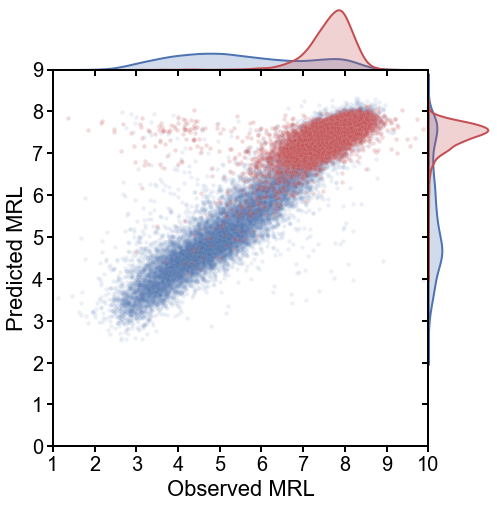

In [69]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, height=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha=0.1, edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1));
ax.set_yticklabels(range(10),size=20);
ax.set_xticks(np.arange(1,10.01, 1));
ax.set_xticklabels(range(1,11),size=20);
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = n_atg['rl'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=0.2, color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig